# Active Anomaly Detection and Continual Learning with Coresets: Experiment Overview

One of the primary issues associated with training a good anomaly detector via the finetuning of a classifier backbone is \textit{catastrophic forgetting}. When a trained classifier moves from the classification task $T_1$ to the novelty detection task $T_2$, we want to continue to perform well on $T_1$ while learning how to do well on task $T_2$.

One proposed method for doing this is the use of \textit{exemplars} or \textit{coresets}. One applicable coreset method that has been presented recently was the method by Borsos et al., presented at Neurips 2021, where a coreset is carefully selected to preserve performance on previous tasks. This method specifically associates weights with each training example and the goal is to construct a coreset of size $m$ to minimize

\begin{equation}
  L(\theta,w)=\sum_{i=1}w_i\ell_i(\theta)
\end{equation}

To omit an example $i$ from the set of exemplars, one can simply set $w_i=0$. We then find our weights $\hat{w}$ via

\begin{equation} \tag{2}
  \hat{w}\in \argmin_{w\in\mathbb{R}_{+}^n,\|w\|_0\leq m}L(\theta^*(w))\;\mathrm{s.t.}\;\theta^*(w)\in\argmin_{\theta}L(\theta,w)
\end{equation}

We want to train a good anomaly detector while retaining training set classification performance using this mechanism.

### Finetuning a Classifier to get an Anomaly Detector
Since we are dealing with a batched online learning scenario, we want to extract information from each new set of labeled examples that will be received during round $t$. This will be done by finetuning the backbone network via outlier exposure with uniform cross-entropy loss regularization term. Our fine-tuning objective is

\begin{equation} \tag{3}
  \mathbb{E}_{(x,y)~\mathcal{D}_{in}}[-\log f_y(x)]+\lambda\mathbb{E}_{x~\mathcal{D}_{out}^{OE}}[H(\mathcal{U};f(x))]
\end{equation}

Anomaly scores are extracted from the finetuned network via the scoring function

\begin{equation} \tag{4}
  S(x)=-\max_k \ell_k(x)
\end{equation}

This anomaly scoring function is referred to as the *max logit scoring function*. The negative sign associates higher scores with more anomalous instances. 

During each round, finetuning will be done on the new data augmented with the training coreset.


### The SAIL-ON Dataset
The SAIL-ON Dataset is comprised of images and relevant metadata that specifies bounding boxes for the *subject*, *verb*, and *object* in each. Each image is not guaranteed to have a subject, verb, and object, however. For example, some images only contain an object and specify an object bounding box accordingly. As an example of a cropped and normalized image,

| Category | Image | Label |
| ----------- | --------- | ----------- |
| Subject | <img src="subject_example_image.jpg" alt="subject" width="200"/> | Person |
| Verb | <img src="verb_example_image.jpg" alt="verb" width="200"/> | Ride |
| Object |<img src="object_example_image.jpg" alt="object" width="200"/> | Bicycle |



# Feature Extraction

We start by setting up the data, importing relevant packages, and initializing our SVO dataset and dataloader.

In [ ]:
import torch
import torchvision

from data.svodataset import SVODataset
from torchvision.models import resnet18

def custom_collate(batch):
    subject_images = []
    verb_images = []
    object_images = []
    spatial_encodings = []
    subject_labels = []
    verb_labels = []
    object_labels = []
    for subject_image, verb_image, object_image, spatial_encoding, subject_label, verb_label, object_label in batch:
        subject_images.append(subject_image)
        verb_images.append(verb_image)
        object_images.append(object_image)
        spatial_encodings.append(spatial_encoding)
        subject_labels.append(subject_label)
        verb_labels.append(verb_label)
        object_labels.append(object_label)

    return subject_images, verb_images, object_images, spatial_encodings, subject_labels, verb_labels, object_labels

train_dataset = SVODataset(
    name = 'Custom',
    data_root = 'Custom',
    csv_path = 'Custom/annotations/dataset_v4_2_train.csv',
    training = True
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle = True,
    collate_fn = custom_collate
)

test_dataset = SVODataset(
    name = 'Custom',
    data_root = 'Custom',
    csv_path = 'Custom/annotations/dataset_v4_2_val.csv',
    training = False
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 16,
    shuffle = True,
    collate_fn = custom_collate
)

Next, we initialize our trained subject classifier and feature extractor.

In [ ]:
bottleneck_dim = 256
num_subject_classes = 5

state_dicts = torch.load(f'new_subject_classifier.pth')

feature_extractor = resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Linear(feature_extractor.fc.weight.shape[1], bottleneck_dim)
subject_classifier = torch.nn.Linear(bottleneck_dim, num_subject_classes)

feature_extractor.load_state_dict(state_dicts['feature_extractor'])
subject_classifier.load_state_dict(state_dicts['classifier'])

Here, we want to run examples through our network to extract the latent subject representations, $\mathbf{z}$. These can be used to run experiments on our margin loss classifier. *If these are already saved locally, then you don't need to run this again. Instead, move on to the next code block.*

In [ ]:
feature_extractor.eval()
subject_classifier.eval()
def extract_nom_anom_datasets(dataloader, embeddings=False):
    nom = None
    nom_labels = None

    anom = None
    anom_labels  = None

    iter_num = 0

    for subject_images, verb_images, object_images, spatial_encodings, subject_labels, verb_labels, object_labels in dataloader:
        for subject_image, verb_image, object_image, spatial_encoding, subject_label, verb_label, object_label in zip(subject_images, verb_images, object_images, spatial_encodings, subject_labels, verb_labels, object_labels):
            if subject_image is not None:

                if embeddings:
                    subject = feature_extractor(torch.unsqueeze(subject_image,0))
                else:
                    subject = torch.unsqueeze(subject_image, 0)

                # # Novel label is 0
                if subject_label != 0:
                    if nom is None:
                        nom = subject
                    else:
                        nom = torch.vstack((nom, subject))

                    if nom_labels is None:
                        nom_labels = torch.unsqueeze(subject_label,0)
                    else:
                        nom_label_dim_last = nom_labels.shape[0]
                        nom_labels = torch.vstack((nom_labels, torch.unsqueeze(subject_label,0)))
                        nom_label_dim_now = nom_labels.shape[0]

                        assert nom_labels.shape[0] == nom.shape[0], f"X: {nom.shape} and y: {nom_labels.shape} mismatch, iter num is {iter_num}"
                        assert nom_label_dim_last == nom_label_dim_now-1, "nom_label dimension changed"

                else:
                    if anom is None:
                        anom = subject
                    else:
                        anom = torch.vstack((anom, subject))

                    if anom_labels is None:
                        anom_labels = torch.unsqueeze(subject_label,0)
                    else:
                        anom_labels = torch.vstack((anom_labels, torch.unsqueeze(subject_label,0)))

            iter_num += 1

    subject_nom_dataset  = torch.utils.data.TensorDataset(nom,  nom_labels)
    subject_anom_dataset = torch.utils.data.TensorDataset(anom, anom_labels)

    return subject_nom_dataset, subject_anom_dataset

train_nom_dataset, train_anom_dataset = extract_nom_anom_datasets(train_data_loader, embeddings=True)
torch.save(train_nom_dataset, 's_z_train_nom_dataset.pt')
torch.save(train_anom_dataset, 's_z_train_anom_dataset.pt')

test_nom_dataset, test_anom_dataset = extract_nom_anom_datasets(test_data_loader, embeddings=True)
torch.save(test_nom_dataset, 's_z_test_nom_dataset.pt')
torch.save(test_anom_dataset, 's_z_test_anom_dataset.pt')

# Coreset Computation (Bypass for now)

The method used to compute our training coreset can be seen in the [paper](https://arxiv.org/pdf/2006.03875.pdf) by Borsos et al. or in the corresponding [git repo](https://github.com/zalanborsos/bilevel_coresets). In the following steps we draw heavily from the code found there.

Our baseline with which we compare the coreset results is the case where we draw a uniform random sample from the training data of size $m$ and use that in lieu of our coreset. We start by implementing the baseline.

In [ ]:
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F

subset_size = 50

np.random.seed(0)
torch.manual_seed(0)

# choose random inds
uniform_inds = np.random.choice(train_dataset.data.shape[0], subset_size, replace=False)
uniform_subset = Subset(train_dataset, uniform_inds)

# Outlier Exposure Loss

Here, we adopt a loss function that depends on an instances novelty or lack thereof. If a given instance is novel, we employ a uniform cross entropy loss over the known classes and use this as our gradient signal. Alternatively, if an instance is known, we use label imputation. This means that even though we have binary label 0, we use label smoothing.

\begin{equation} \tag{5}
  k^*=\argmax_k \ell(k)
\end{equation}

where $\ell(k)$ is the logit of class $k$. We then set the target value for class $k^*$ to be a smoothed label with some $\alpha$ value.

In [ ]:
import torch.nn as nn

train_nom_dataset  = torch.load('s_z_train_nom_dataset.pt')
train_anom_dataset = torch.load('s_z_train_anom_dataset.pt')
test_anom_dataset  = torch.load('s_z_test_anom_dataset.pt')
test_nom_dataset   = torch.load('s_z_test_nom_dataset.pt')

test_anom_dataloader   = \
        torch.utils.data.DataLoader(
            test_anom_dataset,
            batch_size = 8,
            shuffle = True,
            num_workers = 0
        )

test_nom_dataloader   = \
        torch.utils.data.DataLoader(
            test_nom_dataset,
            batch_size = 8,
            shuffle = True,
            num_workers = 0
        )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
subject_classifier.to(device)
subject_classifier.eval()
with torch.no_grad():
    m = nn.Softmax(dim=1)
    correct = 0
    total = 0
    for i, (X, y) in enumerate(test_nom_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = m(subject_classifier(X))
        y_pred = torch.argmax(y_pred, dim=1)

        correct += torch.sum(torch.squeeze(y)==y_pred)
        total += X.shape[0]

    accuracy = correct/total
    print(f"Number correct: {correct}")
    print(f"accuracy is {accuracy}")

In [ ]:
import torch.nn as nn
import torch.backends.cudnn as cudnn
from tqdm import tqdm

torch.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

alphas = [0.01, 0.03, 0.1, 0.3]
learning_rates = [3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
learning_rate = 1e-3
alpha = 0.01
lambda_l2 = 1e-5
batch_size = 8

num_known_classes = 4

train_nom_dataset  = torch.load('s_z_train_nom_dataset.pt')
train_anom_dataset = torch.load('s_z_train_anom_dataset.pt')
test_anom_dataset  = torch.load('s_z_test_anom_dataset.pt')
test_nom_dataset   = torch.load('s_z_test_nom_dataset.pt')

train_anom_dataloader = \
        torch.utils.data.DataLoader(
            train_anom_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 0
        )
test_nom_dataloader   = \
        torch.utils.data.DataLoader(
            test_nom_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 0
        )

novel_loss = nn.CrossEntropyLoss()
#known_loss = nn.CrossEntropyLoss(label_smoothing=alpha)

optimizer = torch.optim.SGD(subject_classifier.parameters(), lr=learning_rate, weight_decay=lambda_l2)

m = torch.nn.Softmax(dim=1)
one_hot = torch.nn.functional.one_hot

subject_classifier.train()
subject_classifier.to(device)

# Since there are only 73 examples in train_anom, this should only utilize
# 73 of the known in instances in the test set, leaving the rest for testing.
# There are 721 nominal examples in the test nom set total.

losses = []
lr_losses = []
alpha_losses = []
num_batches = len(train_anom_dataset) // batch_size

for alpha in [0.01]:
    #optimizer = torch.optim.SGD(subject_classifier.parameters(), lr=lr, weight_decay=lambda_l2)
    known_loss = nn.CrossEntropyLoss(label_smoothing=alpha)
    losses = []
    for i in range(1):
        for j, ((anom_X, anom_y), (nom_X, nom_y)) in tqdm(enumerate(zip(train_anom_dataloader, test_nom_dataloader))):

            anom_X = anom_X.to(device)
            nom_X  = nom_X.to(device)

            # Keep this line uncommented for detection feedback
            nom_y = torch.zeros_like(nom_y)

            # Feed forward
            anom_predictions = m(subject_classifier(anom_X)[:,1:5])
            nom_predictions  = m(subject_classifier(nom_X)[:,1:5])
            
            # Keep this line uncommented for detection feedback
            nom_y_orig = nom_y
            nom_y = torch.argmax(nom_predictions, dim=1)+1 #[:,1:5]

            # If the instance is anomalous, use uniform labeling
            # NOTE: label matrix is (batch_size x num_nominal_classes)
            anom_y = (1/num_known_classes)*torch.ones((len(anom_y),num_known_classes))

            # Converting the nominal labels to be one-hot. Note that these
            # will be label-smoothed when loss is computed
            nom_y = torch.squeeze(one_hot(nom_y-1, num_known_classes).float()) #nom_y = torch.argmax(nom_predictions, dim=1)+1 #[:,1:5]

            anom_y = anom_y.to(device)
            nom_y = nom_y.to(device)

            # Compute loss. Note that arguments are (input, target).
            #
            # Input needs to be (batch_size x num_classes).
            # Target needs to be same shape as input since it contains class
            # probabilities.
            loss = novel_loss(anom_predictions, anom_y) + known_loss(nom_predictions, nom_y)
            losses.append(loss)

            # Zero the optimizer's gradients
            optimizer.zero_grad()

            # Backpropagate to compute the gradients
            # of the loss with respect to our learnable
            # parameters
            loss.backward()

            # Update the learnable parameters
            optimizer.step()
    
    alpha_losses.append(losses)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

batches = np.arange(0,len(losses))

fig, ax = plt.subplots(1, figsize=(8,6))

fig.suptitle('Alpha Sweep', fontsize=15)

for i, alpha in enumerate(alphas):
    ax.plot(batches, alpha_losses[i], label=f'alpha={alpha}')

plt.legend(loc='best')
plt.xlabel('Batch Number (16 instances/batch)')
plt.ylabel('Loss')
plt.show()

# plt.plot(batches, losses)
# plt.title('Batch Training: Log Loss')
# plt.xlabel('Batch Number (16 instances/batch)')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
test_anom_dataloader   = \
        torch.utils.data.DataLoader(
            test_anom_dataset,
            batch_size = 8,
            shuffle = True,
            num_workers = 0
        )

subject_classifier.eval()
with torch.no_grad():
    m = nn.Softmax(dim=1)
    correct = 0
    total = 0
    for i, (X, y) in enumerate(test_nom_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = m(subject_classifier(X))
        y_pred = torch.argmax(y_pred, dim=1)

        correct += torch.sum(torch.squeeze(y)==y_pred)
        total += X.shape[0]

    accuracy = correct/total
    print(f"Number correct: {correct}")
    print(f"accuracy is {accuracy}")

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for i, (X, y) in enumerate(test_anom_dataloader):
        y = torch.zeros_like(y)
        #y = torch.ones_like(y)
        X, y = X.to(device), y.to(device)
        y_pred = subject_classifier(X)
        y_pred, _ = torch.max(y_pred, dim=1)
        y_pred *= -1
       
        y_pred = torch.where(y_pred>-3, 1, 0)

        print(y_pred)
        print(y)

        correct += torch.sum(torch.squeeze(y)==y_pred)
        total += X.shape[0]

    accuracy = correct/total
    print(f"Number correct: {correct}")
    print(f"accuracy is {accuracy}")

## Using 2-fold cross validation for hyperparameter tuning

In [ ]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.backends.cudnn as cudnn
from tqdm import tqdm

torch.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = True

dset1 = train_anom_dataset
dset2X, dset2y = test_nom_dataset[0:len(dset1)]
dset2 = torch.utils.data.TensorDataset(dset2X, dset2y)

dset = torch.utils.data.ConcatDataset([dset1, dset2])

num_epochs = 10
batch_size = 16
k = 2
splits = KFold(n_splits=k, shuffle=True, random_state=0)
fold_performance = {}


In [ ]:
def train_oe_epoch(model,device,dataloader,known_loss_fn,novel_loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)

        print(labels)

        kn_idxs  = [i for i in labels if i != 0]
        nov_idxs = [i for i in labels if i == 0]
        kn_output, kn_labels   = images[kn_idxs],  labels[kn_idxs]
        nov_output, nov_labels = images[nov_idxs], labels[nov_idxs]

        print(kn_labels)
        print(nov_labels)

        loss = known_loss_fn(kn_output,kn_labels) + novel_loss_fn(nov_output,nov_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [ ]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = ConvNet()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt') 

In [ ]:
# As a sanity check, see how it performs on known examples in test set.
# Alex said that it should be ~95% accurate
dset = torch.load('s_X_test_nom_dataset.pt')
dl = torch.utils.data.DataLoader(dset, batch_size=8, shuffle=True, num_workers=0)
with torch.no_grad():
    m = nn.Softmax(dim=1)
    correct = 0
    total = 0
    for i, (X, y) in enumerate(dl):
        # print(y)
        y_pred = feature_extractor(X)
        y_pred = m(subject_classifier(y_pred))
        # print(y_pred)
        y_pred = torch.argmax(y_pred, dim=1)
        # print(y_pred)

        correct += torch.sum(torch.squeeze(y)==y_pred)
        total += X.shape[0]
        #print(f"correct: {correct}\ntotal: {total}")

    accuracy = correct/total
    print(f"Number correct: {correct}")
    print(f"accuracy is {accuracy}")

As a simple experiment, we want to compare these results with margin loss results from previous experiments.

In [ ]:
def anomalyMarginLoss(outputs, labels, tau=0.5, mu=0.2):
    ''' 
    Score A(x_q) = -max_k \sum_{j=1}^d w_{kj} z_{qj} 
    
    k: class
    q: query number
    j: feature number
    
    L(W) = max(0, [A(x_i) - (\tao + \mu n_i)(-n_i)])

    where n_i is the label corresponding to example i:

    +1: novel
    -1: nominal
    
    Args:
        outputs: A(x_i)
        labels:  n_i
    '''
    adjusted = (outputs-(tau+mu*labels))*(-labels)
    instancewise_loss =  torch.maximum(torch.zeros_like(adjusted),adjusted)
    return torch.sum(instancewise_loss)


class AnomalyFC(nn.Module):
    ''' This will be a single fc layer with no activation '''
    def __init__(self, D_in, D_out):
        super(AnomalyFC, self).__init__()
        self.linear = nn.Linear(D_in, D_out)

    def forward(self, x):
        # Computing the logits
        x = self.linear(x)

        # And, finally, an anomaly score
        x = -(torch.max(x,1)[0])
        return x

# Baseline with Outlier Exposure

Training a 4-class Resnet-18 on the union of the OSU known training data and the OSU Feedback Dataset using outlier exposure.

Prep the data.

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_known_classes = 4

batch_size = 64

train_nom_dataset  = torch.load('s_X_train_nom_dataset.pt')
train_anom_dataset = torch.load('s_X_train_anom_dataset.pt')
test_anom_dataset  = torch.load('s_X_test_anom_dataset.pt')
test_nom_dataset   = torch.load('s_X_test_nom_dataset.pt')

dset1X, dset1y = train_anom_dataset[0:]
dset1 = torch.utils.data.TensorDataset(dset1X, torch.hstack((dset1y, torch.zeros_like(dset1y))))
dset2X, dset2y = test_nom_dataset[0:len(dset1)]
dset2 = torch.utils.data.TensorDataset(dset2X, torch.hstack((dset2y, torch.zeros_like(dset2y))))
dset3X, dset3y = train_nom_dataset[0:]
dset3 = torch.utils.data.TensorDataset(dset3X, torch.hstack((dset3y, torch.ones_like(dset3y))))

dset = torch.utils.data.ConcatDataset([dset1, dset2, dset3])

dset_test1X, dset_test1y = test_nom_dataset[len(dset1):]
dset_test1 = torch.utils.data.TensorDataset(dset_test1X, dset_test1y)
dset_test2 = test_anom_dataset

dset_test = torch.utils.data.ConcatDataset([dset_test1, dset_test2])

Specify the model.

In [2]:
# Transfer learning
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Freeze the backbone weights
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_known_classes)

model.to(device)

m = torch.nn.Softmax(dim=1)
one_hot = torch.nn.functional.one_hot

Using cache found in /home/tom/.cache/torch/hub/pytorch_vision_v0.10.0


Specify the hyperparameters. We'll use k-fold for validation.

In [3]:
alpha=0.1
num_epochs = 100
k = 4
splits = KFold(n_splits=k, shuffle=True, random_state=42)
fold_perf = {}

Detection Feedback Helper Functions.

In [4]:
from sklearn.metrics import roc_auc_score

def train_detection_epoch_orig(model,device,dataloader,trainex_loss,novel_loss,known_loss,optimizer):
    tau = -3
    train_loss,train_correct=0.0,0
    model.train()

    nscores = []
    ascores = []
    tscores = []

    for images, labels_tensor in dataloader:

        train_known_label_flags = labels_tensor[:,1]
        labels = labels_tensor[:,0]

        # To convert to detection setup
        train_mask = train_known_label_flags > 0
        feedback_novel_mask = (train_known_label_flags == 0) & (labels == 0)
        feedback_nomin_mask = (train_known_label_flags == 0) & (labels != 0)

        # print(f'feedback_novel_mask: {feedback_novel_mask}')
        # print(f'feedback_nomin_mask: {feedback_nomin_mask}')

        train_X = images[torch.squeeze(train_mask),:]
        train_y = labels[train_mask]
        
        # print(f'feedback_novel_mask shape: {feedback_novel_mask.shape}')
        feedback_nov_X = images[torch.squeeze(feedback_novel_mask),:]
        feedback_nov_y = labels[feedback_novel_mask]

        # print(f'feedback_nomin_mask shape: {feedback_nomin_mask.shape}')
        feedback_nom_X = images[torch.squeeze(feedback_nomin_mask),:]
        feedback_nom_y = labels[feedback_nomin_mask]

        # print(f'train_y shape: {train_y.shape}')
        # print(f'feedback_nov_y shape: {feedback_nov_y.shape}')
        # print(f'feedback_nom_y shape: {feedback_nom_y.shape}')

        if feedback_nov_X.shape[0] != 0:
            feedback_nov_X = feedback_nov_X.to(device)
            novel_logits = model(feedback_nov_X)
            novel_output = novel_logits #m(novel_logits)
            # If the instance is anomalous, use uniform labeling
            # NOTE: label matrix is (batch_size x num_nominal_classes)
            feedback_nov_y = (1/num_known_classes)*torch.ones((feedback_nov_y.shape[0],num_known_classes))

        if feedback_nom_X.shape[0] != 0:
            feedback_nom_X = feedback_nom_X.to(device)
            nom_logits = model(feedback_nom_X)
            nom_output = nom_logits #m(nom_logits)
            feedback_nom_y = torch.argmax(nom_output, dim=1)
            #feedback_nom_y = torch.squeeze(one_hot(feedback_nom_y, num_known_classes).float())

        if train_X.shape[0] != 0:
            train_X = train_X.to(device)
            train_logits = model(train_X)
            train_output = train_logits #m(train_logits)

        train_y = torch.squeeze(one_hot(train_y-1, num_known_classes).float())

        # Compute the loss
        if feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            # print(f'train_output shape: {train_output.shape}')
            # print(f'train_y shape: {train_y.shape}')
            # print(f'novel_output shape: {novel_output.shape}')
            # print(f'feedback_nov_y shape: {feedback_nov_y.shape}')
            # print(f'nom_output shape: {nom_output.shape}')
            # print(f'feedback_nom_y shape: {feedback_nom_y.shape}')
            # # print(f'nom output: {nom_output}')
            # # print(f'nominal labels: {feedback_nom_y}')
            # print(f'novel outputs: {novel_output}')
            # print(f'novel labels: {feedback_nov_y}')
            # print(f'nom output: {nom_output}')
            # print(f'nom labels: {feedback_nom_y}')
            # print(f'train output: {train_output}')
            # print(f'train labels: {train_y}')
            loss = trainex_loss(train_output, train_y) \
                     + known_loss(nom_output, feedback_nom_y) \
                     + novel_loss(novel_output, feedback_nov_y)
        elif feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + novel_loss(novel_output, feedback_nov_y)
        elif feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y) \
                    + novel_loss(novel_output, feedback_nov_y)
        elif train_X.shape[0] != 0:
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y)
        elif feedback_nom_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            loss = novel_loss(novel_output, feedback_nov_y)


        loss /= images.shape[0]

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        if feedback_nov_X.shape[0] != 0:
            novel_scores, novel_predictions = torch.max(novel_logits.data, 1)
            novel_scores *= -1

        if feedback_nom_X.shape[0] != 0:
            nom_scores, nom_predictions = torch.max(nom_logits.data, 1)
            nom_scores *= -1

        if train_X.shape[0] != 0:
            train_scores, nom_predictions = torch.max(train_logits.data, 1)
            train_scores *= -1


        if feedback_nov_X.shape[0] != 0:
            ascores = ascores + [i for i in novel_scores]
        if feedback_nom_X.shape[0] != 0:
            nscores = nscores + [i for i in nom_scores]
        if train_X.shape[0] != 0:
            tscores = tscores + [i for i in train_scores]

    ascores = torch.tensor(ascores)
    nscores = torch.tensor(nscores)
    tscores = torch.tensor(tscores)
    y_true  = torch.hstack((torch.ones_like(ascores), torch.zeros_like(nscores), torch.zeros_like(tscores)))
    y_score = torch.hstack((ascores, nscores, tscores))
    train_auc = roc_auc_score(y_true, y_score)

    return train_loss,None,train_auc

# TODO: Fix the detection by using logits to compute scores instead of softmaxed logits
def valid_detection_epoch_orig(model,device,dataloader,trainex_loss,novel_loss,known_loss):
    tau = -3
    val_loss,val_correct=0.0,0
    model.eval()

    nscores = []
    ascores = []
    tscores = []

    for images, labels_tensor in dataloader:

        train_known_label_flags = labels_tensor[:,1]
        labels = labels_tensor[:,0]

        # To convert to detection setup
        train_mask = train_known_label_flags > 0
        feedback_novel_mask = (train_known_label_flags == 0) & (labels == 0)
        feedback_nomin_mask = (train_known_label_flags == 0) & (labels != 0)

        # print(f'feedback_novel_mask: {feedback_novel_mask}')
        # print(f'feedback_nomin_mask: {feedback_nomin_mask}')

        train_X = images[torch.squeeze(train_mask),:]
        train_y = labels[train_mask]
        
        # print(f'feedback_novel_mask shape: {feedback_novel_mask.shape}')
        feedback_nov_X = images[torch.squeeze(feedback_novel_mask),:]
        feedback_nov_y = labels[feedback_novel_mask]

        # print(f'feedback_nomin_mask shape: {feedback_nomin_mask.shape}')
        feedback_nom_X = images[torch.squeeze(feedback_nomin_mask),:]
        feedback_nom_y = labels[feedback_nomin_mask]

        # print(f'train_y shape: {train_y.shape}')
        # print(f'feedback_nov_y shape: {feedback_nov_y.shape}')
        # print(f'feedback_nom_y shape: {feedback_nom_y.shape}')

        if feedback_nov_X.shape[0] != 0:
            feedback_nov_X = feedback_nov_X.to(device)
            novel_logits = model(feedback_nov_X)
            novel_output = novel_logits #m(novel_logits)
            # If the instance is anomalous, use uniform labeling
            # NOTE: label matrix is (batch_size x num_nominal_classes)
            feedback_nov_y = (1/num_known_classes)*torch.ones((feedback_nov_y.shape[0],num_known_classes))

        if feedback_nom_X.shape[0] != 0:
            feedback_nom_X = feedback_nom_X.to(device)
            nom_logits = model(feedback_nom_X)
            nom_output = nom_logits #m(nom_logits)
            feedback_nom_y = torch.argmax(nom_output, dim=1)
            #feedback_nom_y = torch.squeeze(one_hot(feedback_nom_y, num_known_classes).float())

        if train_X.shape[0] != 0:
            train_X = train_X.to(device)
            train_logits = model(train_X)
            train_output = train_logits #m(train_logits)

        train_y = torch.squeeze(one_hot(train_y-1, num_known_classes).float())

        # Compute the loss
        if feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                     + known_loss(nom_output, feedback_nom_y) \
                     + novel_loss(novel_output, feedback_nov_y)
        elif feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + novel_loss(novel_output, feedback_nov_y)
        elif feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y) \
                    + novel_loss(novel_output, feedback_nov_y)
        elif train_X.shape[0] != 0:
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y)
        elif feedback_nom_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            loss = novel_loss(novel_output, feedback_nov_y)

        loss /= images.shape[0]
        val_loss += loss.item() * images.size(0)

        if feedback_nov_X.shape[0] != 0:
            novel_scores, novel_predictions = torch.max(novel_logits.data, 1)
            novel_scores *= -1

        if feedback_nom_X.shape[0] != 0:
            nom_scores, nom_predictions = torch.max(nom_logits.data, 1)
            nom_scores *= -1

        if train_X.shape[0] != 0:
            train_scores, nom_predictions = torch.max(train_logits.data, 1)
            train_scores *= -1

        if feedback_nov_X.shape[0] != 0:
            ascores = ascores + [i for i in novel_scores]
        if feedback_nom_X.shape[0] != 0:
            nscores = nscores + [i for i in nom_scores]
        if train_X.shape[0] != 0:
            tscores = tscores + [i for i in train_scores]

    ascores = torch.tensor(ascores)
    nscores = torch.tensor(nscores)
    tscores = torch.tensor(tscores)
    y_true  = torch.hstack((torch.ones_like(ascores), torch.zeros_like(nscores), torch.zeros_like(tscores)))
    y_score = torch.hstack((ascores, nscores, tscores))
    val_auc = roc_auc_score(y_true, y_score)

    return val_loss,None,val_auc

This is a copy for running experiment 1.1.b.i.3

In [ ]:
from sklearn.metrics import roc_auc_score

def train_detection_epoch(model,device,dataloader,trainex_loss,novel_loss,known_loss,optimizer):
    tau = -3
    train_loss,train_correct=0.0,0
    model.train()

    nscores = []
    ascores = []
    tscores = []

    for images, labels_tensor in dataloader:

        train_known_label_flags = labels_tensor[:,1]
        labels = labels_tensor[:,0]

        # To convert to detection setup
        train_mask = (train_known_label_flags > 0) | ((train_known_label_flags == 0) & (labels != 0))
        feedback_novel_mask = (train_known_label_flags == 0) & (labels == 0)
        feedback_nomin_mask = torch.tensor([False for i in range(labels.shape[0])]) #(train_known_label_flags == 0) & (labels != 0)

        # print(f'feedback_novel_mask: {feedback_novel_mask}')
        # print(f'feedback_nomin_mask: {feedback_nomin_mask}')

        train_X = images[torch.squeeze(train_mask),:]
        train_y = labels[train_mask]
        
        # print(f'feedback_novel_mask shape: {feedback_novel_mask.shape}')
        feedback_nov_X = images[torch.squeeze(feedback_novel_mask),:]
        feedback_nov_y = labels[feedback_novel_mask]

        # print(f'feedback_nomin_mask shape: {feedback_nomin_mask.shape}')
        feedback_nom_X = images[torch.squeeze(feedback_nomin_mask),:]
        feedback_nom_y = labels[feedback_nomin_mask]

        # print(f'train_y shape: {train_y.shape}')
        # print(f'feedback_nov_y shape: {feedback_nov_y.shape}')
        # print(f'feedback_nom_y shape: {feedback_nom_y.shape}')

        if feedback_nov_X.shape[0] != 0:
            feedback_nov_X = feedback_nov_X.to(device)
            novel_logits = model(feedback_nov_X)
            novel_output = novel_logits #m(novel_logits)
            # If the instance is anomalous, use uniform labeling
            # NOTE: label matrix is (batch_size x num_nominal_classes)
            feedback_nov_y = (1/num_known_classes)*torch.ones((feedback_nov_y.shape[0],num_known_classes))

        if feedback_nom_X.shape[0] != 0:
            feedback_nom_X = feedback_nom_X.to(device)
            nom_logits = model(feedback_nom_X)
            nom_output = nom_logits #m(nom_logits)
            feedback_nom_y = torch.argmax(nom_output, dim=1)
            #feedback_nom_y = torch.squeeze(one_hot(feedback_nom_y, num_known_classes).float())

        if train_X.shape[0] != 0:
            train_X = train_X.to(device)
            train_logits = model(train_X)
            train_output = train_logits #m(train_logits)

        train_y = torch.squeeze(one_hot(train_y-1, num_known_classes).float())

        # Compute the loss
        if feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            # print(f'train_output shape: {train_output.shape}')
            # print(f'train_y shape: {train_y.shape}')
            # print(f'novel_output shape: {novel_output.shape}')
            # print(f'feedback_nov_y shape: {feedback_nov_y.shape}')
            # print(f'nom_output shape: {nom_output.shape}')
            # print(f'feedback_nom_y shape: {feedback_nom_y.shape}')
            # # print(f'nom output: {nom_output}')
            # # print(f'nominal labels: {feedback_nom_y}')
            # print(f'novel outputs: {novel_output}')
            # print(f'novel labels: {feedback_nov_y}')
            # print(f'nom output: {nom_output}')
            # print(f'nom labels: {feedback_nom_y}')
            # print(f'train output: {train_output}')
            # print(f'train labels: {train_y}')
            loss = trainex_loss(train_output, train_y) \
                    + known_loss(nom_output, feedback_nom_y)
                    #+ novel_loss(novel_output, feedback_nov_y) \
        elif feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) #\
                    #+ novel_loss(novel_output, feedback_nov_y)
        elif feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y) #\
                    #novel_loss(novel_output, feedback_nov_y)
        elif train_X.shape[0] != 0:
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y)
        elif feedback_nom_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            loss = 0 # novel_loss(novel_output, feedback_nov_y)


        loss /= images.shape[0]

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        if feedback_nov_X.shape[0] != 0:
            novel_scores, novel_predictions = torch.max(novel_logits.data, 1)
            novel_scores *= -1

        if feedback_nom_X.shape[0] != 0:
            nom_scores, nom_predictions = torch.max(nom_logits.data, 1)
            nom_scores *= -1

        if train_X.shape[0] != 0:
            train_scores, nom_predictions = torch.max(train_logits.data, 1)
            train_scores *= -1


        if feedback_nov_X.shape[0] != 0:
            ascores = ascores + [i for i in novel_scores]
        if feedback_nom_X.shape[0] != 0:
            nscores = nscores + [i for i in nom_scores]
        if train_X.shape[0] != 0:
            tscores = tscores + [i for i in train_scores]

    ascores = torch.tensor(ascores)
    nscores = torch.tensor(nscores)
    tscores = torch.tensor(tscores)
    y_true  = torch.hstack((torch.ones_like(ascores), torch.zeros_like(nscores), torch.zeros_like(tscores)))
    y_score = torch.hstack((ascores, nscores, tscores))
    train_auc = roc_auc_score(y_true, y_score)

    return train_loss,None,train_auc

# TODO: Fix the detection by using logits to compute scores instead of softmaxed logits
def valid_detection_epoch(model,device,dataloader,trainex_loss,novel_loss,known_loss):
    tau = -3
    val_loss,val_correct=0.0,0
    model.eval()

    nscores = []
    ascores = []
    tscores = []

    for images, labels_tensor in dataloader:

        train_known_label_flags = labels_tensor[:,1]
        labels = labels_tensor[:,0]

        # To convert to detection setup
        train_mask = (train_known_label_flags > 0) | ((train_known_label_flags == 0) & (labels != 0))
        feedback_novel_mask = (train_known_label_flags == 0) & (labels == 0)
        feedback_nomin_mask = torch.tensor([False for i in range(labels.shape[0])]) #(train_known_label_flags == 0) & (labels != 0)

        # print(f'feedback_novel_mask: {feedback_novel_mask}')
        # print(f'feedback_nomin_mask: {feedback_nomin_mask}')

        train_X = images[torch.squeeze(train_mask),:]
        train_y = labels[train_mask]
        
        # print(f'feedback_novel_mask shape: {feedback_novel_mask.shape}')
        feedback_nov_X = images[torch.squeeze(feedback_novel_mask),:]
        feedback_nov_y = labels[feedback_novel_mask]

        # print(f'feedback_nomin_mask shape: {feedback_nomin_mask.shape}')
        feedback_nom_X = images[torch.squeeze(feedback_nomin_mask),:]
        feedback_nom_y = labels[feedback_nomin_mask]

        # print(f'train_y shape: {train_y.shape}')
        # print(f'feedback_nov_y shape: {feedback_nov_y.shape}')
        # print(f'feedback_nom_y shape: {feedback_nom_y.shape}')

        if feedback_nov_X.shape[0] != 0:
            feedback_nov_X = feedback_nov_X.to(device)
            novel_logits = model(feedback_nov_X)
            novel_output = novel_logits #m(novel_logits)
            # If the instance is anomalous, use uniform labeling
            # NOTE: label matrix is (batch_size x num_nominal_classes)
            feedback_nov_y = (1/num_known_classes)*torch.ones((feedback_nov_y.shape[0],num_known_classes))

        if feedback_nom_X.shape[0] != 0:
            feedback_nom_X = feedback_nom_X.to(device)
            nom_logits = model(feedback_nom_X)
            nom_output = nom_logits #m(nom_logits)
            feedback_nom_y = torch.argmax(nom_output, dim=1)
            #feedback_nom_y = torch.squeeze(one_hot(feedback_nom_y, num_known_classes).float())

        if train_X.shape[0] != 0:
            train_X = train_X.to(device)
            train_logits = model(train_X)
            train_output = train_logits #m(train_logits)

        train_y = torch.squeeze(one_hot(train_y-1, num_known_classes).float())

        # Compute the loss
        if feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + known_loss(nom_output, feedback_nom_y) #\
                    #+ novel_loss(novel_output, feedback_nov_y)
        elif feedback_nom_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) \
                    + known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0 and train_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y) #\
                    #+ novel_loss(novel_output, feedback_nov_y)
        elif feedback_nov_X.shape[0] != 0 and feedback_nom_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y) #\
                   # + novel_loss(novel_output, feedback_nov_y)
        elif train_X.shape[0] != 0:
            train_y = train_y.to(device)
            loss = trainex_loss(train_output, train_y)
        elif feedback_nom_X.shape[0] != 0:
            feedback_nom_y = feedback_nom_y.to(device)
            loss = known_loss(nom_output, feedback_nom_y)
        elif feedback_nov_X.shape[0] != 0:
            feedback_nov_y = feedback_nov_y.to(device)
            loss = 0 #novel_loss(novel_output, feedback_nov_y)

        loss /= images.shape[0]
        val_loss += loss.item() * images.size(0)

        if feedback_nov_X.shape[0] != 0:
            novel_scores, novel_predictions = torch.max(novel_logits.data, 1)
            novel_scores *= -1

        if feedback_nom_X.shape[0] != 0:
            nom_scores, nom_predictions = torch.max(nom_logits.data, 1)
            nom_scores *= -1

        if train_X.shape[0] != 0:
            train_scores, nom_predictions = torch.max(train_logits.data, 1)
            train_scores *= -1

        if feedback_nov_X.shape[0] != 0:
            ascores = ascores + [i for i in novel_scores]
        if feedback_nom_X.shape[0] != 0:
            nscores = nscores + [i for i in nom_scores]
        if train_X.shape[0] != 0:
            tscores = tscores + [i for i in train_scores]

    ascores = torch.tensor(ascores)
    nscores = torch.tensor(nscores)
    tscores = torch.tensor(tscores)
    y_true  = torch.hstack((torch.ones_like(ascores), torch.zeros_like(nscores), torch.zeros_like(tscores)))
    y_score = torch.hstack((ascores, nscores, tscores))
    val_auc = roc_auc_score(y_true, y_score)

    return val_loss,None,val_auc

In [5]:
import matplotlib.pyplot as plt

novel_loss = nn.CrossEntropyLoss(reduction='sum')
known_loss = nn.CrossEntropyLoss(label_smoothing=alpha, reduction='sum')
trainex_loss = nn.CrossEntropyLoss(reduction='sum')

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler  = SubsetRandomSampler(val_idx)
    train_loader  = DataLoader(dset, batch_size=batch_size, sampler=train_sampler)
    test_loader   = DataLoader(dset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_known_classes)
    model.to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.001, nesterov=True)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[],'train_auc':[],'test_auc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct, train_auc=train_detection_epoch_orig(model,device,train_loader,trainex_loss,novel_loss,known_loss,optimizer)
        with torch.no_grad():
            test_loss, test_correct, test_auc=valid_detection_epoch_orig(model,device,test_loader,trainex_loss,novel_loss,known_loss)

        train_loss = train_loss / len(train_loader.sampler)
        #train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        #test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} Train Loss: {:.3f} Val Loss: {:.3f} Train AUC:{:.3f} Test AUC:{:.3f}".format(epoch + 1, num_epochs, train_loss, test_loss, train_auc, test_auc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        #history['train_acc'].append(train_acc)
        #history['test_acc'].append(test_acc)
        history['train_auc'].append(train_auc)
        history['test_auc'].append(test_auc)

    fold_perf['fold{}'.format(fold+1)] = history  

    torch.save(model,f'baseline_logit_ll_{fold+1}th_fold_{k}_folds_cross_kn_label_imputation.pt')

# Move over working experiment to a different script
# This includes:
#  1) Data processing
#  2) Model Declaration/Definition
#  3) Loss Function Code
#  4) Optimizer Declaration
#  5) Training and Validation Code


Fold 1


Using cache found in /home/tom/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch:1/100 Train Loss: 0.997 Val Loss: 0.655 Train AUC:0.597 Test AUC:0.797
Epoch:2/100 Train Loss: 0.527 Val Loss: 0.513 Train AUC:0.782 Test AUC:0.883
Epoch:3/100 Train Loss: 0.375 Val Loss: 0.408 Train AUC:0.818 Test AUC:0.843
Epoch:4/100 Train Loss: 0.316 Val Loss: 0.356 Train AUC:0.871 Test AUC:0.857
Epoch:5/100 Train Loss: 0.264 Val Loss: 0.328 Train AUC:0.863 Test AUC:0.847
Epoch:6/100 Train Loss: 0.229 Val Loss: 0.338 Train AUC:0.905 Test AUC:0.877
Epoch:7/100 Train Loss: 0.212 Val Loss: 0.305 Train AUC:0.905 Test AUC:0.856
Epoch:8/100 Train Loss: 0.192 Val Loss: 0.295 Train AUC:0.920 Test AUC:0.832
Epoch:9/100 Train Loss: 0.174 Val Loss: 0.267 Train AUC:0.926 Test AUC:0.834
Epoch:10/100 Train Loss: 0.155 Val Loss: 0.289 Train AUC:0.961 Test AUC:0.854
Epoch:11/100 Train Loss: 0.156 Val Loss: 0.295 Train AUC:0.933 Test AUC:0.863
Epoch:12/100 Train Loss: 0.144 Val Loss: 0.272 Train AUC:0.950 Test AUC:0.867
Epoch:13/100 Train Loss: 0.137 Val Loss: 0.285 Train AUC:0.939 Test AUC:0

Using cache found in /home/tom/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch:1/100 Train Loss: 1.150 Val Loss: 0.655 Train AUC:0.544 Test AUC:0.827
Epoch:2/100 Train Loss: 0.560 Val Loss: 0.425 Train AUC:0.738 Test AUC:0.861
Epoch:3/100 Train Loss: 0.389 Val Loss: 0.364 Train AUC:0.798 Test AUC:0.875
Epoch:4/100 Train Loss: 0.314 Val Loss: 0.335 Train AUC:0.837 Test AUC:0.877
Epoch:5/100 Train Loss: 0.270 Val Loss: 0.295 Train AUC:0.876 Test AUC:0.852
Epoch:6/100 Train Loss: 0.243 Val Loss: 0.318 Train AUC:0.899 Test AUC:0.871
Epoch:7/100 Train Loss: 0.216 Val Loss: 0.259 Train AUC:0.909 Test AUC:0.844
Epoch:8/100 Train Loss: 0.187 Val Loss: 0.338 Train AUC:0.913 Test AUC:0.895
Epoch:9/100 Train Loss: 0.179 Val Loss: 0.262 Train AUC:0.927 Test AUC:0.859
Epoch:10/100 Train Loss: 0.160 Val Loss: 0.271 Train AUC:0.935 Test AUC:0.881
Epoch:11/100 Train Loss: 0.153 Val Loss: 0.259 Train AUC:0.932 Test AUC:0.859
Epoch:12/100 Train Loss: 0.148 Val Loss: 0.245 Train AUC:0.950 Test AUC:0.852
Epoch:13/100 Train Loss: 0.135 Val Loss: 0.249 Train AUC:0.942 Test AUC:0

Using cache found in /home/tom/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch:1/100 Train Loss: 1.059 Val Loss: 0.706 Train AUC:0.565 Test AUC:0.754
Epoch:2/100 Train Loss: 0.541 Val Loss: 0.483 Train AUC:0.717 Test AUC:0.774
Epoch:3/100 Train Loss: 0.374 Val Loss: 0.430 Train AUC:0.826 Test AUC:0.752
Epoch:4/100 Train Loss: 0.310 Val Loss: 0.398 Train AUC:0.824 Test AUC:0.812
Epoch:5/100 Train Loss: 0.257 Val Loss: 0.350 Train AUC:0.867 Test AUC:0.816
Epoch:6/100 Train Loss: 0.225 Val Loss: 0.331 Train AUC:0.888 Test AUC:0.816
Epoch:7/100 Train Loss: 0.199 Val Loss: 0.303 Train AUC:0.929 Test AUC:0.805
Epoch:8/100 Train Loss: 0.189 Val Loss: 0.313 Train AUC:0.895 Test AUC:0.801
Epoch:9/100 Train Loss: 0.160 Val Loss: 0.295 Train AUC:0.931 Test AUC:0.796
Epoch:10/100 Train Loss: 0.157 Val Loss: 0.335 Train AUC:0.925 Test AUC:0.887
Epoch:11/100 Train Loss: 0.138 Val Loss: 0.325 Train AUC:0.947 Test AUC:0.847
Epoch:12/100 Train Loss: 0.129 Val Loss: 0.379 Train AUC:0.957 Test AUC:0.839
Epoch:13/100 Train Loss: 0.125 Val Loss: 0.273 Train AUC:0.957 Test AUC:0

Using cache found in /home/tom/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch:1/100 Train Loss: 1.011 Val Loss: 0.634 Train AUC:0.547 Test AUC:0.786
Epoch:2/100 Train Loss: 0.538 Val Loss: 0.420 Train AUC:0.745 Test AUC:0.803
Epoch:3/100 Train Loss: 0.384 Val Loss: 0.370 Train AUC:0.838 Test AUC:0.805
Epoch:4/100 Train Loss: 0.313 Val Loss: 0.317 Train AUC:0.851 Test AUC:0.829
Epoch:5/100 Train Loss: 0.265 Val Loss: 0.312 Train AUC:0.869 Test AUC:0.801
Epoch:6/100 Train Loss: 0.232 Val Loss: 0.292 Train AUC:0.895 Test AUC:0.806
Epoch:7/100 Train Loss: 0.218 Val Loss: 0.284 Train AUC:0.907 Test AUC:0.832
Epoch:8/100 Train Loss: 0.194 Val Loss: 0.266 Train AUC:0.908 Test AUC:0.846
Epoch:9/100 Train Loss: 0.172 Val Loss: 0.279 Train AUC:0.923 Test AUC:0.854
Epoch:10/100 Train Loss: 0.167 Val Loss: 0.294 Train AUC:0.934 Test AUC:0.793
Epoch:11/100 Train Loss: 0.147 Val Loss: 0.296 Train AUC:0.939 Test AUC:0.845
Epoch:12/100 Train Loss: 0.145 Val Loss: 0.280 Train AUC:0.943 Test AUC:0.834
Epoch:13/100 Train Loss: 0.137 Val Loss: 0.261 Train AUC:0.949 Test AUC:0

In [ ]:
sampler = SubsetRandomSampler([i for i in range(len(dset_test))])

test_test_loader = DataLoader(dset_test, batch_size=batch_size, sampler=sampler)
model_a = torch.load('baseline_1th_fold_4_folds_cross_kn_label_imputation.pt')
model_b = torch.load('baseline_2th_fold_4_folds_cross_kn_label_imputation.pt')
model_c = torch.load('baseline_3th_fold_4_folds_cross_kn_label_imputation.pt')
model_d = torch.load('baseline_4th_fold_4_folds_cross_kn_label_imputation.pt')
model_a.eval()
model_b.eval()
model_c.eval()
model_d.eval()

models = [model_a, model_b, model_c, model_d]

def test_detection(models,device,dataloader):
    total_scores = []
    total_labels = []

    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)

        labels = torch.tensor([1 if label == 0 else 0 for label in labels])
        outputs = []

        for model in models:
            outputs.append(model(images))

        sum = torch.zeros_like(outputs[0])

        for output in outputs:
            sum += output

        avg_logits = sum / len(outputs)

        scores, _ = torch.max(-1*avg_logits.data, 1)

        total_scores = total_scores + [i for i in scores]
        total_labels = total_labels + [i for i in labels]

    total_scores = torch.tensor(total_scores)
    total_labels = torch.tensor(total_labels)
    y_true  = torch.reshape(total_labels, total_scores.shape)
    y_score = total_scores
    val_auc = roc_auc_score(y_true, y_score)

    return val_auc

test_auc = test_detection(models, device, test_test_loader)
print(test_auc)

Multiclass (Oracle) Helper Functions.

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_known_classes = 4

batch_size = 64

train_nom_dataset  = torch.load('s_X_train_nom_dataset.pt')
train_anom_dataset = torch.load('s_X_train_anom_dataset.pt')
test_anom_dataset  = torch.load('s_X_test_anom_dataset.pt')
test_nom_dataset   = torch.load('s_X_test_nom_dataset.pt')

dset1 = train_anom_dataset
dset2X, dset2y = test_nom_dataset[0:len(dset1)]
dset2 = torch.utils.data.TensorDataset(dset2X, dset2y)
dset3 = train_nom_dataset

dset = torch.utils.data.ConcatDataset([dset1, dset2, dset3])

dset_test1X, dset_test1y = test_nom_dataset[len(dset1):]
dset_test1 = torch.utils.data.TensorDataset(dset_test1X, dset_test1y)
dset_test2 = test_anom_dataset

dset_test = torch.utils.data.ConcatDataset([dset_test1, dset_test2])

train_dataloader   = \
        torch.utils.data.DataLoader(
            dset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 8
        )

test_dataloader   = \
        torch.utils.data.DataLoader(
            dset_test,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 8
        )


# Transfer learning
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_known_classes)
model.to(device)

#print(model(next(iter(train_dataloader))[0].to(device)).shape)

m = torch.nn.Softmax(dim=1)
one_hot = torch.nn.functional.one_hot

alpha=0.1
num_epochs = 100
k = 4
splits = KFold(n_splits=k, shuffle=True, random_state=42)
fold_perf = {}

In [ ]:
# TODO: Writing DONE. Debugging IN PROGRESS
def train_epoch(model,device,dataloader,novel_loss,known_loss,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        #images,labels = images.to(device),labels.to(device)
        
        optimizer.zero_grad()

        novel_idx = torch.tensor([i for i in range(len(labels)) if labels[i] == 0])
        nom_idx = torch.tensor([i for i in range(len(labels)) if labels[i] != 0])
        novel_images = images[novel_idx.long(),:]
        novel_y = labels[novel_idx.long()]
        nom_images = images[nom_idx.long(),:]
        nom_y = labels[nom_idx.long()]

        if novel_images.shape[0] != 0:
            novel_images = novel_images.to(device)

        nom_images   = nom_images.to(device)

        # Keep this line uncommented for detection feedback
        # nom_y = torch.zeros_like(nom_y)

        # Feed forward
        if novel_images.shape[0] != 0:
            novel_output = m(model(novel_images))
        nom_output = m(model(nom_images))
        
        # Keep this line uncommented for detection feedback
        # nom_y_orig = nom_y
        # nom_y = torch.argmax(nom_output, dim=1)

        # If the instance is anomalous, use uniform labeling
        # NOTE: label matrix is (batch_size x num_nominal_classes)
        novel_y_orig = novel_y
        novel_y = (1/num_known_classes)*torch.ones((len(novel_y),num_known_classes))

        # Converting the nominal labels to be one-hot. Note that these
        # will be label-smoothed when loss is computed.
        nom_y_orig = convert_to_model_labels(nom_y) # UNCOMMENT FOR MULTICLASS FEEDBACK
        nom_y = torch.squeeze(one_hot(nom_y_orig, num_known_classes).float())

        if novel_images.shape[0] != 0:
            novel_y = novel_y.to(device)
        nom_y = nom_y.to(device)

        if novel_images.shape[0] != 0:
            loss = novel_loss(novel_output, novel_y) \
                    + known_loss(nom_output, nom_y)
        else:
            loss = known_loss(nom_output, nom_y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        if novel_images.shape[0] != 0:
            novel_scores, novel_predictions = torch.max(novel_output.data, 1)

        nom_scores, nom_predictions = torch.max(nom_output.data, 1)

        # print(nom_predictions.shape)
        # print(nom_y_orig.shape)

        if novel_images.shape[0] != 0:
            # print(novel_predictions.shape)
            # print(novel_y_orig.shape)
            train_correct += (novel_predictions == torch.squeeze(novel_y_orig).to(device)).sum().item()

        train_correct += (nom_predictions == torch.squeeze(nom_y_orig).to(device)).sum().item()

    return train_loss,train_correct

# TODO: Writing DONE. Debugging IN PROGRESS
def valid_epoch(model,device,dataloader,novel_loss,known_loss):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)

        novel_idx = torch.tensor([i for i in range(len(labels)) if labels[i] == 0])
        nom_idx = torch.tensor([i for i in range(len(labels)) if labels[i] != 0])
        novel_images = images[novel_idx.long(),:]
        novel_y = labels[novel_idx.long()]
        nom_images = images[nom_idx.long(),:]
        nom_y = labels[nom_idx.long()]

        nom_images   = nom_images.to(device)

        # Keep this line uncommented for detection feedback
        # nom_y = torch.zeros_like(nom_y)

        # Feed forward
        if novel_images.shape[0] != 0:
            novel_output = m(model(novel_images))
        nom_output = m(model(nom_images))
        
        # Keep this line uncommented for detection feedback
        # nom_y_orig = nom_y
        # nom_y = torch.argmax(nom_output, dim=1)

        # If the instance is anomalous, use uniform labeling
        # NOTE: label matrix is (batch_size x num_nominal_classes)
        novel_y_orig = novel_y
        novel_y = (1/num_known_classes)*torch.ones((len(novel_y),num_known_classes))

        # Converting the nominal labels to be one-hot. Note that these
        # will be label-smoothed when loss is computed
        nom_y_orig = convert_to_model_labels(nom_y) # UNCOMMENT FOR MULTICLASS FEEDBACK
        nom_y = torch.squeeze(one_hot(nom_y_orig, num_known_classes).float())

        if novel_images.shape[0] != 0:
            novel_y = novel_y.to(device)
        nom_y = nom_y.to(device)

        if novel_images.shape[0] != 0:
            loss = novel_loss(novel_output, novel_y) \
                    + known_loss(nom_output, nom_y)
        else:
            loss = known_loss(nom_output, nom_y)

        valid_loss+=loss.item()*images.size(0)

        if novel_images.shape[0] != 0:
            novel_scores, novel_predictions = torch.max(novel_output.data, 1)
            
        nom_scores, nom_predictions = torch.max(nom_output.data, 1)
        
        if novel_images.shape[0] != 0:
            val_correct += (novel_predictions == torch.squeeze(novel_y_orig).to(device)).sum().item()

        val_correct += (nom_predictions == torch.squeeze(nom_y_orig).to(device)).sum().item()

    return valid_loss,val_correct

def convert_to_model_labels(nom_labels):
    return nom_labels - 1

Specify the loss.

In [ ]:
novel_loss = nn.CrossEntropyLoss()
known_loss = nn.CrossEntropyLoss() #label_smoothing=alpha) # Don't use label smoothing for known_loss unless you're performing detection feedback experiments

Cross-validate.

In [ ]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_known_classes)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,novel_loss,known_loss,optimizer)
        with torch.no_grad():
            test_loss, test_correct=valid_epoch(model,device,test_loader,novel_loss,known_loss)

        print(train_correct)
        print(len(train_loader.sampler))

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    fold_perf['fold{}'.format(fold+1)] = history  

    torch.save(model,f'baseline_{fold+1}th_fold_{k}_folds_cross_kn_label_imputation.pt')

In [6]:
import copy
folds_copy = copy.deepcopy(fold_perf)
print(folds_copy.keys())

dict_keys(['fold1', 'fold2', 'fold3', 'fold4'])


In [7]:
print(folds_copy['fold1'].keys())

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc', 'train_auc', 'test_auc'])


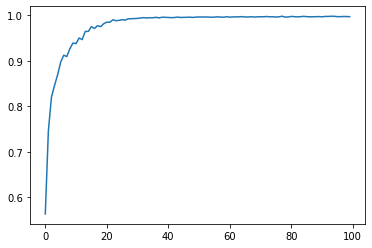

In [8]:
import matplotlib.pyplot as plt

def average_entries(data_dict, key):
    meta_keys = list(data_dict.keys())
    num_folds = len(meta_keys)
    assert(len(meta_keys) > 0)
    keys = list(data_dict[meta_keys[0]].keys())
    assert(len(keys) > 0)
    num_entries = len(data_dict[meta_keys[0]][keys[0]])

    avg_data = []
    for i in range(num_entries):
        sum = 0
        for fold in meta_keys:
            sum += data_dict[fold][key][i]
        avg_data.append(sum/num_folds)

    return avg_data


avgs = {}
avgs['train_loss'] = average_entries(folds_copy, 'train_loss')
avgs['test_loss']  = average_entries(folds_copy, 'test_loss')
# avgs['train_acc']  = average_entries(folds_copy, 'train_acc')
# avgs['test_acc']   = average_entries(folds_copy, 'test_acc')
avgs['train_auc'] = average_entries(folds_copy, 'train_auc')
avgs['test_auc']  = average_entries(folds_copy, 'test_auc')

plt.plot(avgs['train_auc'])
plt.show()

In [ ]:
print(type(folds_copy.keys()))
keylist = list(folds_copy.keys())
print(folds_copy[keylist[0]])
print(keylist[0])

In [ ]:
avgs.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


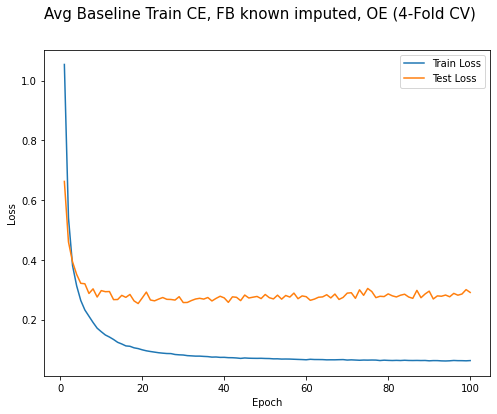

In [10]:
fig, ax = plt.subplots(1, figsize=(8,6))
epochs = [i for i in range(1,101)]
print(epochs)

fig.suptitle('Avg Baseline Train CE, FB known imputed, OE (4-Fold CV)', fontsize=15)

ax.plot(epochs, avgs['train_loss'], label='Train Loss')
ax.plot(epochs, avgs['test_loss'], label='Test Loss')
# # ax.plot(epochs, avgs['train_acc'], label='Train Accuracy')
# # ax.plot(epochs, avgs['test_acc'], label='Test Accuracy')

# ax.plot(epochs, avgs['train_auc'], label='Train AUC')
# ax.plot(epochs, avgs['test_auc'], label='Test AUC')

plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

torch.save(avgs, 'osu_training_known_ce_osu_feedback_known_imputation_novel_uniform_nft_ll.pt')

In [16]:
import matplotlib.pyplot as plt

# Plotting Test AUCs across all of these experiments
f1 = 'osu_training_known_ce_nft_ll.pt'
f2 = 'osu_training_known_ce_osu_feedback_novel_uniform_ce_nft_ll.pt'
f3 = 'osu_training_known_ce_osu_feedback_known_ce_nft_ll.pt'
f4 = 'osu_training_known_ce_osu_feedback_known_label_imputation_nft_ll.pt'
f5 = 'osu_training_known_ce_osu_feedback_known_imputation_novel_uniform_nft_ll.pt'
file_handles = [f1, f2, f3, f4, f5]

collected_avgs = []

for f in file_handles:
    collected_avgs.append(torch.load(f))

max_x = 30 #len(collected_avgs[0]['test_auc'])
assert(max_x <= len(collected_avgs[0]['test_auc']) and max_x > 0)
x = [i for i in range(max_x)]

# Plotting
for i, avgs in enumerate(collected_avgs):
    plt.plot(x, avgs['test_auc'][0:max_x], label=f'11bi{i+1}')

plt.title('Averaged Test AUCs for Baselines')
plt.xlabel('Epoch')
plt.ylabel('Test AUC')
plt.legend(loc='best')
plt.show()

## Margin Loss Experiments

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_known_classes = 4

batch_size = 64

train_nom_dataset  = torch.load('s_X_train_nom_dataset.pt')
train_anom_dataset = torch.load('s_X_train_anom_dataset.pt')
test_anom_dataset  = torch.load('s_X_test_anom_dataset.pt')
test_nom_dataset   = torch.load('s_X_test_nom_dataset.pt')

dset1 = train_anom_dataset
dset2X, dset2y = test_nom_dataset[0:len(dset1)]
dset2 = torch.utils.data.TensorDataset(dset2X, dset2y)
dset3 = train_nom_dataset

dset = torch.utils.data.ConcatDataset([dset1, dset2, dset3])

dset_test1X, dset_test1y = test_nom_dataset[len(dset1):]
dset_test1 = torch.utils.data.TensorDataset(dset_test1X, dset_test1y)
dset_test2 = test_anom_dataset

dset_test = torch.utils.data.ConcatDataset([dset_test1, dset_test2])

train_dataloader   = \
        torch.utils.data.DataLoader(
            train_nom_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 8
        )

test_dataloader   = \
        torch.utils.data.DataLoader(
            train_nom_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 8
        )

In [ ]:
def anomalyMarginLoss(outputs, labels, tau=0.5, mu=0.2):
    ''' 
    Score A(x_q) = -max_k \sum_{j=1}^d w_{kj} z_{qj} 
    
    k: class
    q: query number
    j: feature number
    
    L(W) = max(0, [A(x_i) - (\tao + \mu n_i)(-n_i)])

    where n_i is the label corresponding to example i:

    +1: novel
    -1: nominal
    
    Args:
        outputs: A(x_i)
        labels:  n_i
    '''
    adjusted = (outputs-(tau+mu*labels))*(-labels)
    instancewise_loss =  torch.maximum(torch.zeros_like(adjusted),adjusted)
    return torch.sum(instancewise_loss)


class AnomalyFC(nn.Module):
    ''' This will be a single fc layer with no activation '''
    def __init__(self, D_in, D_out):
        super(AnomalyFC, self).__init__()
        self.linear = nn.Linear(D_in, D_out)

    def forward(self, x):
        # Computing the logits
        x = self.linear(x)

        # And, finally, an anomaly score
        x = -(torch.max(x,1)[0])
        return x

In [ ]:
from torchvision.models import resnet18

bottleneck_dim = 256
num_subject_classes = 5

state_dicts = torch.load(f'new_subject_classifier.pth')

feature_extractor = resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Linear(feature_extractor.fc.weight.shape[1], bottleneck_dim)
subject_classifier = AnomalyFC(bottleneck_dim, num_subject_classes)

sc_dict = {}
sc_dict['linear.weight'] = state_dicts['classifier']['weight']
sc_dict['linear.bias']   = state_dicts['classifier']['bias']
 
feature_extractor.load_state_dict(state_dicts['feature_extractor'])
subject_classifier.load_state_dict(sc_dict)

feature_extractor.to(device)
subject_classifier.to(device)

m = torch.nn.Softmax(dim=1)
one_hot = torch.nn.functional.one_hot

In [ ]:
import torch.nn as nn
import torch.backends.cudnn as cudnn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

torch.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

alphas = [0.01, 0.03, 0.1, 0.3]
learning_rates = [3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
tau = -4.9
learning_rate = 1e-3
alpha = 0.01
lambda_l2 = 1e-5
batch_size = 16
mus = [i for i in range(0,5)]

num_epochs = 100

num_known_classes = 4

train_nom_dataset  = torch.load('s_z_train_nom_dataset.pt')
train_anom_dataset = torch.load('s_z_train_anom_dataset.pt')
test_anom_dataset  = torch.load('s_z_test_anom_dataset.pt')
test_nom_dataset   = torch.load('s_z_test_nom_dataset.pt')

train_anom_dataloader = \
        torch.utils.data.DataLoader(
            train_anom_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 0
        )
test_nom_dataloader   = \
        torch.utils.data.DataLoader(
            test_nom_dataset,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 0
        )

optimizer = torch.optim.SGD(subject_classifier.parameters(), lr=learning_rate, weight_decay=lambda_l2)

m = torch.nn.Softmax(dim=1)
one_hot = torch.nn.functional.one_hot

subject_classifier.train()
subject_classifier.to(device)

# Since there are only 73 examples in train_anom, this should only utilize
# 73 of the known in instances in the test set, leaving the rest for testing.
# There are 721 nominal examples in the test nom set total.

losses = []
lr_losses = []
alpha_losses = []
mu_losses = []
num_batches = len(train_anom_dataset) // batch_size
mu_accuracies = []
mu_aucs = []

#optimizer = torch.optim.SGD(subject_classifier.parameters(), lr=lr, weight_decay=lambda_l2)
losses = []
accuracies = []

feature_extractor = resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Linear(feature_extractor.fc.weight.shape[1], bottleneck_dim)
subject_classifier = AnomalyFC(bottleneck_dim, num_subject_classes)

sc_dict = {}
sc_dict['linear.weight'] = state_dicts['classifier']['weight']
sc_dict['linear.bias']   = state_dicts['classifier']['bias']

feature_extractor.load_state_dict(state_dicts['feature_extractor'])
subject_classifier.load_state_dict(sc_dict)

feature_extractor.to(device)
subject_classifier.to(device)

for mu in mus:
    losses = []
    accuracies = []
    aucs = []
    for i in range(num_epochs):
        correct = 0
        total   = 0
        scores = []
        labels_arr = []
        for j, ((anom_X, anom_y), (nom_X, nom_y)) in enumerate(zip(train_anom_dataloader, test_nom_dataloader)):

            anom_X = anom_X.to(device)
            nom_X  = nom_X.to(device)
            anom_y = anom_y.to(device)
            nom_y = nom_y.to(device)

            # Feed forward
            anom_predictions = subject_classifier(anom_X)
            nom_predictions  = subject_classifier(nom_X)

            outputs = torch.hstack((nom_predictions, anom_predictions))
            labels  = torch.hstack((torch.zeros_like(nom_predictions), torch.ones_like(anom_predictions)))

            # Compute loss. Note that arguments are (input, target).
            #
            # Input needs to be (batch_size x num_classes).
            # Target needs to be same shape as input since it contains class
            # probabilities.
            loss = anomalyMarginLoss(outputs, labels, tau=tau, mu=mu)
            # losses.append(loss)

            # Zero the optimizer's gradients
            optimizer.zero_grad()

            # Backpropagate to compute the gradients
            # of the loss with respect to our learnable
            # parameters
            loss.backward()

            correct += ((outputs > tau) == torch.squeeze(labels).to(device)).sum().item()
            total += anom_X.shape[0] + nom_X.shape[0]

            # Update the learnable parameters
            optimizer.step()

            scores = scores + [i for i in anom_predictions]
            scores = scores + [i for i in nom_predictions]
            labels_arr = labels_arr + [i for i in labels]

        scores = torch.tensor(scores)
        labels_arr = torch.tensor(labels_arr)
        auc = roc_auc_score(labels_arr, scores)

        losses.append(loss)
        accuracies.append(correct / total)
        aucs.append(auc)
        print(f'mu={mu} epoch={i+1}/{num_epochs} loss={loss} accuracy={correct / total} auc={auc}')

    mu_accuracies.append(accuracies)
    mu_losses.append(losses)
    mu_aucs.append(aucs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

batches = np.arange(0,len(losses))

fig, ax = plt.subplots(1, figsize=(8,6))

fig.suptitle('Mu Sweep', fontsize=15)

for i, mu in enumerate(mus):
    ax.plot(batches, mu_aucs[i], label=f'mu={mu}')

plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.show()